In [5]:
import numpy as np
import pandas as pd
import os
import sys
import io
from os.path import join
from zipfile import ZipFile

import random as rd

import spacy
import tensorflow as tf
from IPython.core.display import display_markdown
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models as models
from torchvision import transforms

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F

import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import FastText
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from catboost import CatBoostClassifier, Pool


from math import ceil
from matplotlib import pyplot as plt
from PIL import Image
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import TextDisplayObject
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Family\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Импорт датасета

In [6]:
dataset_path = 'dataset'

In [7]:
images_zip = os.path.join(dataset_path, 'train.zip')
queries = os.path.join(dataset_path, 'train.tsv')

# test_images_zip = os.path.join(dataset_path, 'test.zip')
# test_queries = os.path.join(dataset_path, 'test_no_target.tsv') # Без таргета

# example_submit = os.path.join(dataset_path, 'example_submit.tsv')

In [8]:
work_dir = 'images'

# Предобработка данных

## Получение данных из датасета

In [9]:
class PurpleFile(Exception): # Битое изображение, ошибка с CRC-32
    pass

In [10]:
def zip2jpeg(zip, png_name, dest):
  preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
    ])
  with ZipFile(zip, 'r') as zip_file:
    if png_name in zip_file.namelist():
        try:
            zip_file.extract(png_name, path=dest)
        except:
            png_name = png_name.replace('/', '\\').replace(':', '_')
            bad_file = Image.new(mode = "RGB", size = (224, 224), color = (153, 153, 255))
            jpeg_name = png_name.replace('.png', '.jpeg')
            bad_file.save(os.path.join(dest, jpeg_name), 'JPEG', quality=50)
            print(f'Bad PNG file {png_name}')
            os.remove(os.path.join(dest, png_name))
            raise PurpleFile(f'Bad PNG file {png_name}')
            #return bad_file
    else:
      print(f'PNG file {png_name} not found in {zip}')
    png_name = png_name.replace('/', '\\').replace(':', '_')
    png_file = Image.open(os.path.join(dest, png_name)).convert('RGB')
    jpeg_name = png_name.replace('.png', '.jpeg')
    png_file.save(os.path.join(dest, jpeg_name), 'JPEG', quality=50)
    jpeg_file = Image.open(os.path.join(dest, jpeg_name)).convert('RGB')
    prep_jpeg_file = preprocess(jpeg_file)
    prep_jpeg_file.save(os.path.join(dest, jpeg_name))
    os.remove(os.path.join(dest, png_name))
    return prep_jpeg_file # JPEG

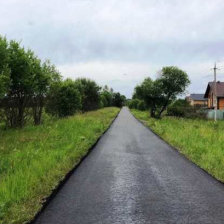

In [11]:
zip2jpeg(images_zip, 'train/competition_data:332057.png', 'images\\train_images')

In [12]:
bad_file = 'train/competition_data:322856.png'
zip2jpeg(images_zip, bad_file, 'images\\train_images')

Bad PNG file train\competition_data_322856.png


PurpleFile: Bad PNG file train\competition_data_322856.png

In [13]:
class TrainDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir, sample_size=-1, val_size=0.1, test_size=0.2):
        self.image_dir = image_dir
        self.zip_file = zip_file
        if sample_size == -1:
          self.data = pd.read_csv(tsv_file, sep='\t')
        else:
          self.data = pd.read_csv(tsv_file, sep='\t')
          self.data = self.data.loc[0:sample_size+1]
            
        train_data, test_data = train_test_split(self.data, test_size=test_size, random_state=42)
        val_size = val_size / (1 - test_size)
        train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=42)
        train_data = train_data.reset_index(drop=True)
        val_data = val_data.reset_index(drop=True)
        test_data = test_data.reset_index(drop=True)
        self.data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg'))):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
        else:
            try:
                image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
            except PurpleFile:
                image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
                self.data.iloc[idx, 1] = "bad file"
                self.data.iloc[idx, 2] = -1
          
        text = str(self.data.iloc[idx, 1])
        target = self.data.iloc[idx, 2]
        return image, str(text), target

In [14]:
class TestDataset(Dataset):
    def __init__(self, zip_file, image_dir, test_data):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = test_data
        label_to_index = {'Плохо' : 0, 'Удовлетворительно' : 1, 'Идеально' : 2}
        self.data['mark_index'] = self.data['mark'].map(label_to_index)
        self.data.drop(columns=['mark'], inplace=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg'))):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0].replace('/', '\\').replace(':', '_').replace('.png', '.jpeg')))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = str(self.data.iloc[idx, 1])
        target = self.data.iloc[idx, 2]
        return image, text, target

In [15]:
def dataset_info(name, dataset):
  print('*' * len(name))
  print(name)
  print('*' * len(name))
  dataset.data.info()
  display(dataset.data.head())
  display(dataset.data.describe())
  print('_' * 75)
  for i in range(5):
    image, text, target = dataset[i]
    display(dataset.data.iloc[i])
    display(image)


In [16]:
train_dataset = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [17]:
val_dataset = TestDataset(images_zip,
                         os.path.join(work_dir, 'val_images'), train_dataset.val_data)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [18]:
test_dataset = TestDataset(images_zip,
                           os.path.join(work_dir, 'test_images'), train_dataset.test_data)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

*****************
Обучающая выборка
*****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18179 entries, 0 to 18178
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    18179 non-null  object
 1   text        18179 non-null  object
 2   mark_index  18179 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 426.2+ KB


filename                            text  \
0  train/competition_data:332057.png                 на деревне тихо   
1  train/competition_data:329459.png                     кашкай 2010   
2  train/competition_data:103100.png                           цифры   
3  train/competition_data:280419.png                   ацетат натрия   
4  train/competition_data:243915.png  магазины бутики проекты фасады   

   mark_index  
0           1  
1           2  
2           2  
3           2  
4           2

mark_index
count  18179.000000
mean       1.383960
std        0.626019
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000

___________________________________________________________________________


filename      train/competition_data:332057.png
text                            на деревне тихо
mark_index                                    1
Name: 0, dtype: object

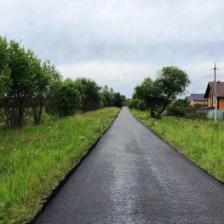

filename      train/competition_data:329459.png
text                                кашкай 2010
mark_index                                    2
Name: 1, dtype: object

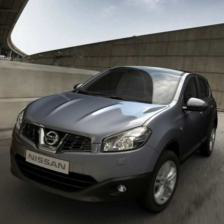

filename      train/competition_data:103100.png
text                                      цифры
mark_index                                    2
Name: 2, dtype: object

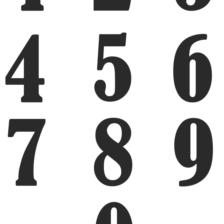

filename      train/competition_data:280419.png
text                              ацетат натрия
mark_index                                    2
Name: 3, dtype: object

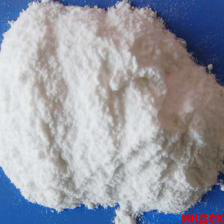

filename      train/competition_data:243915.png
text             магазины бутики проекты фасады
mark_index                                    2
Name: 4, dtype: object

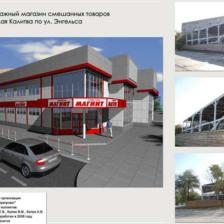

In [19]:
dataset_info('Обучающая выборка', train_dataset)

In [20]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

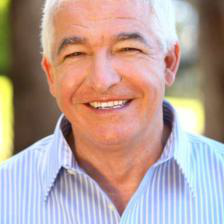

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

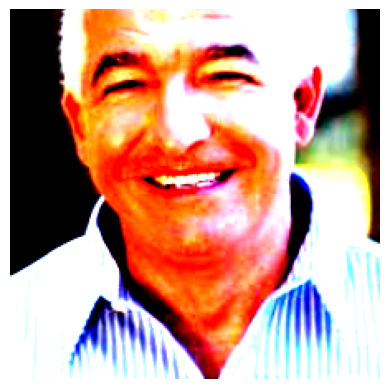

In [21]:
img = train_dataset[6][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

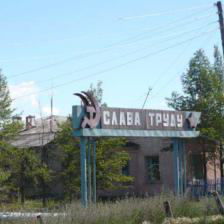

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

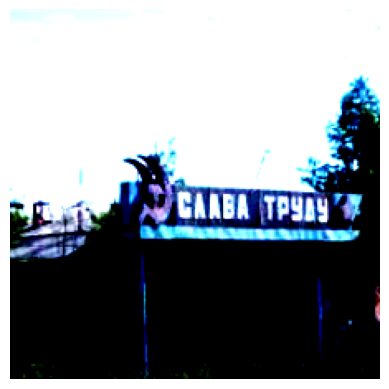

In [22]:
img = val_dataset[3][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

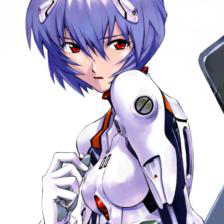

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

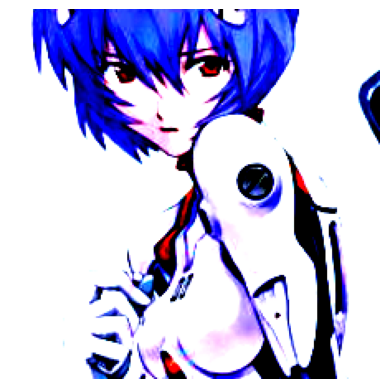

In [23]:
img = test_dataset[3][0]
display(img)

image_tensor = preprocess(img)
image_tensor_np = image_tensor.permute(1, 2, 0).numpy()
plt.imshow(image_tensor_np)
plt.axis('off')
display(plt)

In [24]:
ft_ru = FastText(language='ru')

In [25]:
text = train_dataset[6][1]

# Токенизация текста
tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
# Получение эмбеддингов слов и конкатенация
query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
# Усреднение эмбеддингов слов для получения эмбеддинга запроса
if query_embeddings:
    avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
    vectorized_query = avg_embedding
else:
    # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор
    vectorized_query = torch.zeros(ft_ru.dim)

# Преобразование в тензоры PyTorch
vectorized_query.size()

torch.Size([300])

In [ ]:

resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)

print(list(resnet.children()))

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

In [27]:
img = train_dataset[7][0]
image_tensor = preprocess(img)
img_features = resnet(image_tensor.unsqueeze(0)).flatten()
img_features.size()

torch.Size([512])

## Векторизация

Создадим пробный датасет из первых 10 записей тренировочного подмножества, чтобы проверить работу генераторов эмбеддингов.

In [28]:
def img_emb_gen(dataset):
    img_emb = []
    for idx in range(len(dataset)):
      if dataset[idx][1] == "bad file":
          img_emb.append(np.array([np.nan] * 512))
      else:
          image = dataset[idx][0]
          image_tensor = preprocess(image)
          output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
          img_emb.append(output_tensor.numpy())
    img_emb_df = pd.DataFrame(img_emb, columns=[f'img_emb_{i}' for i in range(512)])
    dataset.data = pd.concat([dataset.data, img_emb_df], axis=1)

In [29]:
safe_slice = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'), 10)

safe_slice.data.head()

filename  \
0   train/competition_data:69788.png   
1   train/competition_data:39076.png   
2  train/competition_data:245180.png   
3  train/competition_data:348773.png   
4  train/competition_data:194818.png   

                                                text  mark_index  
0                          мойдодыр чуковского стихи           1  
1  елена лядова биография личная жизнь муж фото дети           1  
2                        23 февраля нгушского народа           1  
3      игры из геометрических фигур в средней группе           1  
4                                    приседания сумо           2

In [30]:
img_emb_gen(safe_slice)
safe_slice.data.head()

filename  \
0   train/competition_data:69788.png   
1   train/competition_data:39076.png   
2  train/competition_data:245180.png   
3  train/competition_data:348773.png   
4  train/competition_data:194818.png   

                                                text  mark_index  img_emb_0  \
0                          мойдодыр чуковского стихи           1   1.286618   
1  елена лядова биография личная жизнь муж фото дети           1   0.081124   
2                        23 февраля нгушского народа           1   0.905589   
3      игры из геометрических фигур в средней группе           1   1.145411   
4                                    приседания сумо           2   0.579469   

   img_emb_1  img_emb_2  img_emb_3  img_emb_4  img_emb_5  img_emb_6  ...  \
0   2.042780   0.707164   1.724844   0.993646   0.147505   1.091170  ...   
1   0.487796   0.084506   0.389780   0.184029   0.714229   2.125500  ...   
2   0.271512   0.407365   0.000000   0.148655   0.203434   0.189487  ...   
3   0.997833   2.295359   3.884444   0.060729   0.012709   0.133870  ...   
4   0.174476   0.258091   0.324492   0.547961   0.205218   2.073566  ...   

   img_emb_502  img_emb_503  img_emb_504  img_emb_505  img_emb_506  \
0     0.646444     0.578687     2.848514     0.636247     0.020623   
1     1.290295     0.469756     0.340502     0.299844     2.391324   
2     2.496955     0.000000     0.300993     0.485805     0.006021   
3     0.504714     0.083051     1.063785     1.922293     0.428741   
4     0.028091     0.973337     0.175853     1.187411     0.280520   

   img_emb_507  img_emb_508  img_emb_509  img_emb_510  img_emb_511  
0     0.695939     0.657074     1.300950     0.221017     3.648163  
1     1.309070     2.517177     0.150856     0.307128     1.791105  
2     0.629921     0.722826     1.768301     0.137771     2.860086  
3     0.000000     0.179743     0.137213     0.509391     0.208310  
4     1.323242     0.344001     1.027756     0.003152     1.741366  

[5 rows x 515 columns]

In [31]:
def txt_emb_gen(dataset):
  txt_emb = []
  for idx in range(len(dataset)):
    text = dataset[idx][1]
    if text == "bad file":
        txt_emb.append(np.array([np.nan] * 300))
    else:
        # Токенизация текста
        tokens = word_tokenize(text.lower())  # Приведение к нижнему регистру и токенизация
        # Получение эмбеддингов слов и конкатенация
        query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
        # Усреднение эмбеддингов слов для получения эмбеддинга запроса
        if query_embeddings:
            avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
            vectorized_query = avg_embedding
        else:
            # Если запрос состоит только из неизвестных слов, можно использовать нулевой тензор
            vectorized_query = torch.zeros(ft_ru.dim)
        output_tensor = vectorized_query
        txt_emb.append(output_tensor.numpy())
    txt_emb_df = pd.DataFrame(txt_emb, columns=[f'txt_emb_{i}' for i in range(300)])
    dataset.data = pd.concat([dataset.data, txt_emb_df], axis=1)


In [32]:
txt_emb_gen(safe_slice)
safe_slice.data.head()

filename  \
0   train/competition_data:69788.png   
1   train/competition_data:39076.png   
2  train/competition_data:245180.png   
3  train/competition_data:348773.png   
4  train/competition_data:194818.png   

                                                text  mark_index  img_emb_0  \
0                          мойдодыр чуковского стихи           1   1.286618   
1  елена лядова биография личная жизнь муж фото дети           1   0.081124   
2                        23 февраля нгушского народа           1   0.905589   
3      игры из геометрических фигур в средней группе           1   1.145411   
4                                    приседания сумо           2   0.579469   

   img_emb_1  img_emb_2  img_emb_3  img_emb_4  img_emb_5  img_emb_6  ...  \
0   2.042780   0.707164   1.724844   0.993646   0.147505   1.091170  ...   
1   0.487796   0.084506   0.389780   0.184029   0.714229   2.125500  ...   
2   0.271512   0.407365   0.000000   0.148655   0.203434   0.189487  ...   
3   0.997833   2.295359   3.884444   0.060729   0.012709   0.133870  ...   
4   0.174476   0.258091   0.324492   0.547961   0.205218   2.073566  ...   

   txt_emb_290  txt_emb_291  txt_emb_292  txt_emb_293  txt_emb_294  \
0    -0.305333     0.362507    -0.014376    -0.238676     0.450763   
1     0.010964     0.088908     0.255956     0.217713     0.350814   
2     0.177875     0.170020     0.085579    -0.036665     0.121124   
3     0.115447     0.165504    -0.068538    -0.099851     0.106415   
4     0.272700     0.224718    -0.123558    -0.076067     0.281865   

   txt_emb_295  txt_emb_296  txt_emb_297  txt_emb_298  txt_emb_299  
0     0.007341     0.286154    -0.156111     0.024777     0.067855  
1    -0.002694     0.108618    -0.066047    -0.143702    -0.091664  
2    -0.041231    -0.010864    -0.119239     0.002310    -0.019275  
3    -0.063498     0.071625     0.038663    -0.088584     0.172612  
4    -0.004405     0.258924    -0.065039    -0.257920     0.289145  

[5 rows x 2615 columns]

In [33]:
def emb_gen_4_entry(filename, entry):
  entry_w_emb = [filename] + list(entry[1:])
  image = entry[0]
  text = entry[1]
  
  if text == "bad file":
      entry_w_emb.extend(np.array([np.nan] * 512))
      entry_w_emb.extend(np.array([np.nan] * 300))
  else:
      image_tensor = preprocess(image)
      img_emb_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
      entry_w_emb.extend(img_emb_tensor.numpy())

      tokens = word_tokenize(text.lower())
      query_embeddings = [ft_ru[token] for token in tokens if token in ft_ru.stoi]
      if query_embeddings:
          avg_embedding = torch.mean(torch.stack(query_embeddings), dim=0)
          vectorized_query = avg_embedding
      else:
          vectorized_query = torch.zeros(ft_ru.dim)
      txt_emb_tensor = vectorized_query
      entry_w_emb.extend(txt_emb_tensor.numpy())

  return entry_w_emb


In [36]:
def emb_gen(dataset):
  data_w_emb_df = pd.DataFrame(columns=['filename', 'text', 'mark_index'] + [f'img_emb_{i}' for i in range(512)] + [f'txt_emb_{i}' for i in range(300)])
  for idx in range(len(dataset)):
    emb = emb_gen_4_entry(dataset.data['filename'][idx], dataset[idx])
    data_w_emb_df.loc[len(data_w_emb_df)] = emb
  dataset.data = data_w_emb_df

In [37]:
safe_slice = TrainDataset(images_zip, queries,
                              os.path.join(work_dir, 'train_images'), 10)
safe_slice.data.head()


filename  \
0   train/competition_data:69788.png   
1   train/competition_data:39076.png   
2  train/competition_data:245180.png   
3  train/competition_data:348773.png   
4  train/competition_data:194818.png   

                                                text  mark_index  
0                          мойдодыр чуковского стихи           1  
1  елена лядова биография личная жизнь муж фото дети           1  
2                        23 февраля нгушского народа           1  
3      игры из геометрических фигур в средней группе           1  
4                                    приседания сумо           2

In [ ]:
emb_gen_4_entry(safe_slice.data['filename'][0], safe_slice[0])

In [38]:
emb_gen(safe_slice)
safe_slice.data.head()

filename  \
0   train/competition_data:69788.png   
1   train/competition_data:39076.png   
2  train/competition_data:245180.png   
3  train/competition_data:348773.png   
4  train/competition_data:194818.png   

                                                text  mark_index  img_emb_0  \
0                          мойдодыр чуковского стихи           1   1.286618   
1  елена лядова биография личная жизнь муж фото дети           1   0.081124   
2                        23 февраля нгушского народа           1   0.905589   
3      игры из геометрических фигур в средней группе           1   1.145411   
4                                    приседания сумо           2   0.579469   

   img_emb_1  img_emb_2  img_emb_3  img_emb_4  img_emb_5  img_emb_6  ...  \
0   2.042780   0.707164   1.724844   0.993646   0.147505   1.091170  ...   
1   0.487796   0.084506   0.389780   0.184029   0.714229   2.125500  ...   
2   0.271512   0.407365   0.000000   0.148655   0.203434   0.189487  ...   
3   0.997833   2.295359   3.884444   0.060729   0.012709   0.133870  ...   
4   0.174476   0.258091   0.324492   0.547961   0.205218   2.073566  ...   

   txt_emb_290  txt_emb_291  txt_emb_292  txt_emb_293  txt_emb_294  \
0    -0.305333     0.362507    -0.014376    -0.238676     0.450763   
1     0.010964     0.088908     0.255956     0.217713     0.350814   
2     0.177875     0.170020     0.085579    -0.036665     0.121124   
3     0.115447     0.165504    -0.068538    -0.099851     0.106415   
4     0.272700     0.224718    -0.123558    -0.076067     0.281865   

   txt_emb_295  txt_emb_296  txt_emb_297  txt_emb_298  txt_emb_299  
0     0.007341     0.286154    -0.156111     0.024777     0.067855  
1    -0.002694     0.108618    -0.066047    -0.143702    -0.091664  
2    -0.041231    -0.010864    -0.119239     0.002310    -0.019275  
3    -0.063498     0.071625     0.038663    -0.088584     0.172612  
4    -0.004405     0.258924    -0.065039    -0.257920     0.289145  

[5 rows x 815 columns]

In [ ]:
emb_gen(train_dataset)
train_dataset.data.head()

In [266]:
output_path = 'train_embeddings.tsv'

# Записываем DataFrame в .tsv файл
train_dataset.data.to_csv(output_path, sep='\t', index=False)

In [62]:
emb_gen(val_dataset)
val_dataset.data.head()

filename                                 text  \
0  train/competition_data:356804.png              реле поворотов ваз 2108   
1  train/competition_data:300758.png           пушкин песнь о вещем олеге   
2  train/competition_data:243122.png                            чингисхан   
3  train/competition_data:226006.png  колымская трасса посёлок артык фото   
4   train/competition_data:69707.png              спасибо в день животных   

   mark_index  img_emb_0  img_emb_1  img_emb_2  img_emb_3  img_emb_4  \
0           1   0.882019   0.331600   1.393478   1.107286   0.403372   
1           1   0.047598   1.387496   0.138296   0.125963   0.450336   
2           2   0.486313   0.493279   0.155885   0.988383   3.291381   
3           1   0.183766   2.106775   1.487312   0.644463   0.286584   
4           1   0.483893   0.775835   1.377816   1.210344   0.071677   

   img_emb_5  img_emb_6  ...  txt_emb_290  txt_emb_291  txt_emb_292  \
0   0.728179   1.946580  ...    -0.037792     0.493877    -0.451693   
1   1.554241   1.872095  ...    -0.033928     0.077592    -0.120279   
2   0.596136   1.238338  ...     0.169140    -0.180540    -0.293730   
3   0.028932   0.616824  ...    -0.133553     0.124630    -0.223340   
4   0.910250   0.053606  ...     0.299765     0.063409    -0.020606   

   txt_emb_293  txt_emb_294  txt_emb_295  txt_emb_296  txt_emb_297  \
0    -0.067962    -0.201868    -0.527327     0.445634    -0.108790   
1    -0.019855     0.411190    -0.164646     0.170920    -0.236062   
2     0.215780     0.068377    -0.299960     0.204650    -0.221140   
3     0.099273    -0.151735    -0.054234     0.286240    -0.223498   
4     0.062632     0.307995    -0.121782     0.045230    -0.093966   

   txt_emb_298  txt_emb_299  
0     0.055198     0.129204  
1    -0.080563     0.098059  
2    -0.106340     0.510810  
3    -0.049984     0.128226  
4    -0.038945    -0.079632  

[5 rows x 815 columns]

In [63]:
output_path = 'val_embeddings.tsv'

# Записываем DataFrame в .tsv файл
val_dataset.data.to_csv(output_path, sep='\t', index=False)

In [40]:
train_dataset.data = pd.read_csv('train_embeddings.tsv', sep='\t')

In [41]:
val_dataset.data = pd.read_csv('val_embeddings.tsv', sep='\t')

In [42]:
train_dataset.data.shape

(18179, 815)

In [44]:
train_dataset.data = train_dataset.data.dropna(axis='index', how='any')

In [45]:
train_dataset.data = train_dataset.data[train_dataset.data.text != 'bad file']
train_dataset.data.shape

(18177, 815)

In [46]:
val_dataset.data.shape

(2598, 815)

In [47]:
val_dataset.data = val_dataset.data[val_dataset.data.text != 'bad file']
val_dataset.data.shape

(2598, 815)

## Построение бейзлайна

In [48]:
train_emb_data = train_dataset.data[[col for col in train_dataset.data.columns.tolist() if 'emb' in col]]
train_target = train_dataset.data['mark_index']
train_emb_data.head()
train_target.head()

img_emb_0  img_emb_1  img_emb_2  img_emb_3  img_emb_4  img_emb_5  \
0   0.278201   0.821032   0.166536   0.248028   0.458136   0.291936   
1   0.807961   2.171582   1.561773   0.130517   1.256814   0.663316   
2   0.105166   1.291944   0.920511   0.685790   0.277462   0.139710   
3   0.114632   0.850897   0.119262   0.799433   0.013861   0.338646   
4   1.204015   2.677281   3.255516   0.082253   0.513738   0.214894   

   img_emb_6  img_emb_7  img_emb_8  img_emb_9  ...  txt_emb_290  txt_emb_291  \
0   0.235552   0.177262   1.494046   0.496466  ...     0.099019     0.541420   
1   1.076345   0.844646   0.148962   0.599963  ...    -0.067523     0.504700   
2   0.305923   0.077939   1.462002   0.516046  ...    -0.185690    -0.166940   
3   0.153161   0.503462   1.801554   0.217630  ...     0.152187    -0.432295   
4   0.735141   2.995481   0.832272   0.549223  ...    -0.238625     0.174530   

   txt_emb_292  txt_emb_293  txt_emb_294  txt_emb_295  txt_emb_296  \
0    -0.132608     0.168968     0.214560    -0.184447     0.058822   
1    -0.139780     0.580410     0.409440    -0.133280     0.245420   
2    -0.095096     0.089881    -0.201520    -0.409880    -0.063766   
3    -1.038065    -0.327645     0.499395    -0.220160     0.167150   
4    -0.058500    -0.179674     0.239683     0.085981     0.218109   

   txt_emb_297  txt_emb_298  txt_emb_299  
0    -0.284161    -0.063549     0.362464  
1     0.219730    -0.075050     0.192140  
2     0.181350    -0.387580     0.037478  
3    -0.281115     0.020472    -0.461275  
4     0.232022    -0.176253    -0.344548  

[5 rows x 812 columns]

0    1
1    2
2    2
3    2
4    2
Name: mark_index, dtype: int64

In [49]:
val_emb_data = val_dataset.data[[col for col in val_dataset.data.columns.tolist() if 'emb' in col]]
val_target = val_dataset.data['mark_index']
val_emb_data.head()
val_target.head()

img_emb_0  img_emb_1  img_emb_2  img_emb_3  img_emb_4  img_emb_5  \
0   0.882019   0.331600   1.393478   1.107286   0.403372   0.728179   
1   0.047598   1.387496   0.138296   0.125963   0.450336   1.554241   
2   0.486313   0.493279   0.155885   0.988383   3.291381   0.596136   
3   0.183766   2.106775   1.487312   0.644463   0.286584   0.028932   
4   0.483893   0.775835   1.377816   1.210344   0.071677   0.910250   

   img_emb_6  img_emb_7  img_emb_8  img_emb_9  ...  txt_emb_290  txt_emb_291  \
0   1.946580   0.192769   0.588805   0.657106  ...    -0.037792     0.493877   
1   1.872095   0.277209   0.570494   0.366990  ...    -0.033928     0.077592   
2   1.238338   2.320327   0.464798   1.543864  ...     0.169140    -0.180540   
3   0.616824   0.962832   0.079428   1.163571  ...    -0.133553     0.124630   
4   0.053606   0.622221   1.029861   0.295450  ...     0.299765     0.063409   

   txt_emb_292  txt_emb_293  txt_emb_294  txt_emb_295  txt_emb_296  \
0    -0.451693    -0.067962    -0.201868    -0.527327     0.445634   
1    -0.120279    -0.019855     0.411190    -0.164646     0.170920   
2    -0.293730     0.215780     0.068377    -0.299960     0.204650   
3    -0.223340     0.099273    -0.151735    -0.054234     0.286240   
4    -0.020606     0.062632     0.307995    -0.121783     0.045230   

   txt_emb_297  txt_emb_298  txt_emb_299  
0    -0.108790     0.055198     0.129204  
1    -0.236062    -0.080563     0.098059  
2    -0.221140    -0.106340     0.510810  
3    -0.223498    -0.049984     0.128226  
4    -0.093966    -0.038945    -0.079632  

[5 rows x 812 columns]

0    1
1    1
2    2
3    1
4    1
Name: mark_index, dtype: int64

In [50]:
cb_train_data = Pool(train_emb_data, label=train_target)
cb_val_data = Pool(val_emb_data, label=val_target)

# Определение параметров модели
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'l2_leaf_reg': 30,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'verbose': 100,
    'random_seed': 42,
    'use_best_model': True,  # Сохраним лучшую модель
    'eval_metric': 'Accuracy',
}

model_bl = CatBoostClassifier(**params)

In [104]:
model_bl.fit(cb_train_data, eval_set=cb_val_data, plot=True)

model_bl.save_model('base_model.cb')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5427188	test: 0.5373364	best: 0.5373364 (0)	total: 60.5ms	remaining: 1m
100:	learn: 0.6514276	test: 0.5816012	best: 0.5854503 (89)	total: 4.76s	remaining: 42.3s
200:	learn: 0.7056720	test: 0.5839107	best: 0.5881447 (190)	total: 9.13s	remaining: 36.3s
300:	learn: 0.7491335	test: 0.5869900	best: 0.5904542 (283)	total: 13.5s	remaining: 31.3s
400:	learn: 0.7840128	test: 0.5850654	best: 0.5904542 (283)	total: 17.8s	remaining: 26.6s
500:	learn: 0.8121802	test: 0.5854503	best: 0.5904542 (283)	total: 22.1s	remaining: 22s
600:	learn: 0.8341310	test: 0.5854503	best: 0.5904542 (283)	total: 26.4s	remaining: 17.5s
700:	learn: 0.8550366	test: 0.5831409	best: 0.5904542 (283)	total: 30.7s	remaining: 13.1s
800:	learn: 0.8739616	test: 0.5881447	best: 0.5908391 (755)	total: 35s	remaining: 8.7s
900:	learn: 0.8883204	test: 0.5908391	best: 0.5931486 (868)	total: 39.3s	remaining: 4.32s
999:	learn: 0.9026792	test: 0.5885296	best: 0.5931486 (868)	total: 43.6s	remaining: 0us
bestTest = 0.5931485758


In [105]:
print(model_bl.get_best_score())
print(model_bl.get_best_iteration())
print(model_bl.get_all_params())

{'learn': {'Accuracy': 0.903009297463828, 'MultiClass': 0.46887802709124166}, 'validation': {'Accuracy': 0.5931485758275596, 'MultiClass': 0.8447766498568611}}
868
{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'Accuracy', 'iterations': 1000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 30, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': True, 'meta_l2_frequency': 0, 'class_names': [0, 1, 2], 'random_seed': 42, 'depth': 6, 'border_count

Получили значение accuracy почти 0.6, в два раза больше, чем произвольный классификатор. Уже хорошо, но хотелось бы лучше.

Используем GridSearchCV для подбора лучших параметров бустинга.

In [133]:
param_grid = {
    'iterations': [500, 1000, 1500, 2000],
    'learning_rate': [0.1, 0.05, 0.02],
    'l2_leaf_reg': [2, 5, 10, 25],
    'depth': [6, 10, 15, 20]
}
'''
    'task_type': ['GPU'],
    'verbose': [100],
    'random_seed': [42],
    'use_best_model': [True],
    '''

"\n    'task_type': ['GPU'],\n    'verbose': [100],\n    'random_seed': [42],\n    'use_best_model': [True],\n    "

In [134]:
model_gs = CatBoostClassifier()

gs_result = model_gs.grid_search(param_grid,
                                cb_train_data,
                                cv=5,
                                partition_random_seed=42,
                                calc_cv_statistics=True,
                                search_by_train_test_split=True,
                                refit=True,
                                shuffle=True,
                                train_size=0.8,
                                verbose=100, 
                                plot=True
                                 )

print("Лучшие параметры:", gs_result['params'])
print("Лучшая точность:", gs_result['cv_results']['test-MultiClass-mean'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0692064	test: 1.0701164	best: 1.0701164 (0)	total: 403ms	remaining: 3m 20s
1:	learn: 1.0442423	test: 1.0458849	best: 1.0458849 (1)	total: 652ms	remaining: 2m 42s
2:	learn: 1.0226791	test: 1.0247500	best: 1.0247500 (2)	total: 837ms	remaining: 2m 18s
3:	learn: 1.0034841	test: 1.0062583	best: 1.0062583 (3)	total: 1.03s	remaining: 2m 7s
4:	learn: 0.9871462	test: 0.9909819	best: 0.9909819 (4)	total: 1.24s	remaining: 2m 2s
5:	learn: 0.9726106	test: 0.9774406	best: 0.9774406 (5)	total: 1.42s	remaining: 1m 56s
6:	learn: 0.9609630	test: 0.9664616	best: 0.9664616 (6)	total: 1.59s	remaining: 1m 52s
7:	learn: 0.9498213	test: 0.9562801	best: 0.9562801 (7)	total: 1.77s	remaining: 1m 48s
8:	learn: 0.9400865	test: 0.9472624	best: 0.9472624 (8)	total: 2s	remaining: 1m 49s
9:	learn: 0.9309750	test: 0.9392300	best: 0.9392300 (9)	total: 2.23s	remaining: 1m 49s
10:	learn: 0.9238731	test: 0.9323594	best: 0.9323594 (10)	total: 2.42s	remaining: 1m 47s
11:	learn: 0.9176018	test: 0.9267378	best: 0.9

KeyboardInterrupt: 

In [62]:
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'l2_leaf_reg': 15,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',
    'verbose': 100,
    'random_seed': 42,
    'border_count' : 128,
    'use_best_model': True,  # Сохраним лучшую модель
    'eval_metric': 'Accuracy',
}

model_cb = CatBoostClassifier(**params)
model_cb.fit(cb_train_data, eval_set=cb_val_data, plot=True)

model_cb.save_model('best_model.cb')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5427188	test: 0.5373364	best: 0.5373364 (0)	total: 90.1ms	remaining: 1m 30s
100:	learn: 0.6213347	test: 0.5758276	best: 0.5773672 (85)	total: 4.98s	remaining: 44.4s
200:	learn: 0.6657314	test: 0.5850654	best: 0.5873749 (191)	total: 9.48s	remaining: 37.7s
300:	learn: 0.7008857	test: 0.5896844	best: 0.5919938 (243)	total: 13.9s	remaining: 32.2s
400:	learn: 0.7300435	test: 0.5916089	best: 0.5927637 (316)	total: 18.2s	remaining: 27.2s
500:	learn: 0.7554052	test: 0.5862202	best: 0.5931486 (454)	total: 22.6s	remaining: 22.5s
600:	learn: 0.7762007	test: 0.5977675	best: 0.5981524 (596)	total: 27s	remaining: 17.9s
700:	learn: 0.7943555	test: 0.5935335	best: 0.5981524 (596)	total: 31.3s	remaining: 13.4s
800:	learn: 0.8116851	test: 0.5943033	best: 0.5981524 (596)	total: 35.7s	remaining: 8.87s
900:	learn: 0.8293448	test: 0.5912240	best: 0.5985373 (809)	total: 40.6s	remaining: 4.46s
999:	learn: 0.8426583	test: 0.5916089	best: 0.5985373 (809)	total: 45.7s	remaining: 0us
bestTest = 0.5985

In [ ]:
class TestDataset(Dataset):
    def __init__(self, zip_file, tsv_file, image_dir):
        self.image_dir = image_dir
        self.zip_file = zip_file
        self.data = pd.read_csv(tsv_file, sep='\t')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if os.path.exists(os.path.join(self.image_dir, self.data.iloc[idx, 0])):
          image = Image.open(os.path.join(self.image_dir, self.data.iloc[idx, 0]))
        else:
          image = zip2jpeg(self.zip_file, self.data.iloc[idx, 0], self.image_dir)
        text = self.data.iloc[idx, 1]
        return image, text

In [ ]:
test_dataset = TestDataset(test_images_zip, test_queries,
                              os.path.join(work_dir, 'test_images'))

test_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)

In [ ]:
def predict(model, device, dataloader):
    model.eval()  # Установка модели в режим оценки
    predictions = []
    with torch.no_grad():  # Отключение вычисления градиентов
        for images, texts in dataloader:
            # Перемещение данных на устройство и прямой проход через модель
            images = images.to(device)
            texts = texts.to(device)
            outputs = model(images, texts)
            # Применение softmax к выходам модели
            probabilities = F.softmax(outputs, dim=1)
            # Выбор индекса класса с наибольшей вероятностью
            _, predicted = torch.max(probabilities, 1)
            predictions.extend(predicted.cpu().numpy())  # Преобразование индексов к числовому типу и добавление в список
    return images, texts, predictions

# Использование функции predict
device = torch.device('cuda:0')  # Установка устройства (GPU)
test_predictions = predict(model, device, test_dataloader)  # Получение предсказаний для тестовой выборки